In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns


In [5]:
df = pd.read_csv("video_game.csv")

In [6]:
df.head(20)

,Unnamed: 0,Name,Platform,Year_of_Release,Genre,Publisher,NA_players,EU_players,JP_players,Other_players,Global_players,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN
5,6,Tetris,GB,1989.0,Puzzle,Nintendo,23.20,2.26,4.22,0.58,30.26,NaN,NaN,NaN,NaN,NaN,NaN
6,7,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.28,9.14,6.50,2.88,29.80,89.0,65.0,8.5,431.0,Nintendo,E
7,8,Wii Play,Wii,2006.0,Misc,Nintendo,13.96,9.18,2.93,2.84,28.92,58.0,41.0,6.6,129.0,Nintendo,E
8,9,New Super Mario Bros. Wii,Wii,2009.0,Platform,Nintendo,14.44,6.94,4.70,2.24,28.32,87.0,80.0,8.4,594.0,Nintendo,E
9,10,Duck Hunt,NES,1984.0,Shooter,Nintendo,26.93,0.63,0.28,0.47,28.31,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
df['Publisher'].unique()

array(['Nintendo', 'Microsoft Game Studios', 'Take-Two Interactive',
       'Sony Computer Entertainment', 'Activision', 'Ubisoft',
       'Bethesda Softworks', 'Electronic Arts', 'Sega', 'SquareSoft',
       'Atari', '505 Games', 'Capcom', 'GT Interactive',
       'Konami Digital Entertainment', 'Square Enix',
       'Sony Computer Entertainment Europe', 'Virgin Interactive',
       'LucasArts', 'Warner Bros. Interactive Entertainment',
       'Universal Interactive', 'Eidos Interactive', 'RedOctane',
       'Vivendi Games', 'Enix Corporation', 'Namco Bandai Games',
       'Palcom', 'Hasbro Interactive', 'THQ', 'Fox Interactive',
       'Acclaim Entertainment', 'MTV Games', 'Disney Interactive Studios',
       nan, 'Codemasters', 'Majesco Entertainment', 'Red Orb', 'Level 5',
       'Arena Entertainment', 'Midway Games', 'JVC', 'Deep Silver',
       'NCSoft', '989 Studios', 'UEP Systems', 'Parker Bros.', 'Maxis',
       'Imagic', 'Tecmo Koei', 'ASCII Entertainment', 'Valve Software',


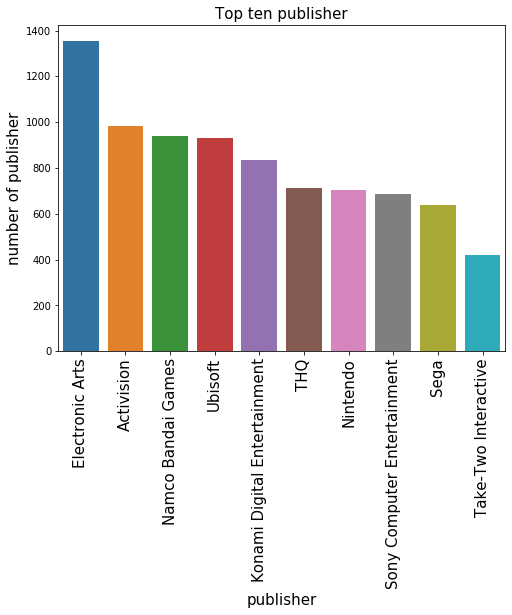

In [14]:
from collections import Counter
publisher = Counter(df['Publisher'].dropna().tolist()).most_common(10)
publisher_name = [name[0] for name in publisher]
publisher_count = [name[1] for name in publisher]

fig,ax = plt.subplots(figsize=(8,6))
sns.barplot(x=publisher_name,y=publisher_count,ax=ax)
plt.title('Top ten publisher',fontsize=15)
plt.ylabel('number of publisher',fontsize=15)
plt.xlabel('publisher',fontsize=15)
ticks = plt.setp(ax.get_xticklabels(),fontsize=15,rotation=90)


In [39]:
publisher_sales = df[['Publisher', 'NA_players', 'EU_players' , 'JP_players']]
publisher_sales.head()

,Publisher,NA_players,EU_players,JP_players
0,Nintendo,41.36,28.96,3.77
1,Nintendo,29.08,3.58,6.81
2,Nintendo,15.68,12.76,3.79
3,Nintendo,15.61,10.93,3.28
4,Nintendo,11.27,8.89,10.22


In [43]:
publisher_list = df['Publisher'].unique()
total_NA_revenue = []
total_EU_revenue = []
total_JP_revenue = []
total_revenue = []
for publisher in publisher_list:
    total_NA_revenue.append(publisher_sales[publisher_sales['Publisher'] == publisher]['NA_players'].sum())
    total_EU_revenue.append(publisher_sales[publisher_sales['Publisher'] == publisher]['EU_players'].sum())
    total_JP_revenue.append(publisher_sales[publisher_sales['Publisher'] == publisher]['JP_players'].sum())

    
for idx in range(len(publisher_list)):
    total_revenue.append(total_NA_revenue[idx] + total_EU_revenue[idx])
    
publisher_revenue_dataframe = pd.DataFrame({'publisher':publisher_list,
                                            'total_NA_Sales':total_NA_revenue,
                                            'total_EU_Sales':total_EU_revenue,
                                            'total_JP_Sales':total_JP_revenue,
                                            'total_revenue':total_revenue
                                            })
publisher_revenue_dataframe = publisher_revenue_dataframe.sort_values(['total_NA_Sales'],
                                                               ascending=False).head()
publisher_revenue_dataframe.reset_index(drop=True).head()

,publisher,total_NA_Sales,total_EU_Sales,total_JP_Sales,total_revenue
0,Nintendo,816.97,419.01,458.15,1235.98
1,Electronic Arts,599.50,373.91,14.35,973.41
2,Activision,432.59,215.90,6.71,648.49
3,Sony Computer Entertainment,266.17,186.56,74.15,452.73
4,Ubisoft,252.74,161.99,7.52,414.73


In [113]:
data2= pd.read_excel('games_evaluation.xlsx')


In [114]:

rate= ['6.8','6.4','5.5','5.9','6.6','5.2','7.4','6.2','5.9','7.6','7.3','6','6.1','6.3','6.5','6.3','6.5','6.5','7.1']
data2['Rate']=rate

In [115]:
data2.head(19)

,Name,Game story,Interface,Gameplay,Music,Optimization,Atmosphere,Rate
0,Battlefield 5,5.7,7.5,7.1,6.7,6.5,7.3,6.8
1,Mafia 3,6.1,6.7,6.5,7.3,5.4,6.2,6.4
2,No Man's Sky,4.9,5.4,5.6,6.1,5.8,5.5,5.5
3,Watch Dogs 1,4.3,6.5,6.3,6.1,6.1,6.3,5.9
4,Assassin's Creed Unity,7.0,7.0,6.4,7.1,5.2,7.1,6.6
5,Call of duty\nAdvanced warfare,6.6,7.6,7.3,6.5,6.7,7.0,5.2
6,Fallout 76,4.7,5.3,5.6,5.7,5.0,4.9,7.4
7,Batman: Arkham Knight,8.1,7.9,7.5,6.9,6.4,7.7,6.2
8,Warcraft III: Reforged,7.5,6.0,5.0,5.9,6.1,6.5,5.9
9,Aliens: Colonial Marines,5.1,6.1,5.8,5.9,6.5,6.2,7.6


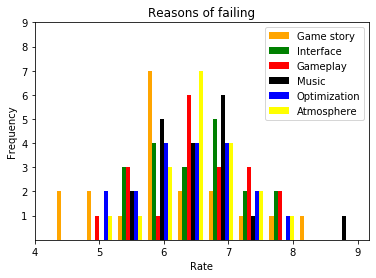

In [102]:
data2= pd.read_excel('games_evaluation.xlsx')
total_story = data2['Game story']
legend = ['Game story', 'Interface', 'Gameplay', 'Music','Optimization','Atmosphere']
total_int = data2['Interface']
total_game = data2['Gameplay']
total_mus = data2['Music']
total_opt = data2['Optimization']
total_atm = data2['Atmosphere']
plt.hist([total_story,total_int, total_game, total_mus, total_opt, total_atm], color=['orange', 'green' ,'red', 'black', 'blue', 'yellow'])
plt.xlabel("Rate")
plt.ylabel("Frequency")
plt.legend(legend)
plt.xticks(range(4, 10))
plt.yticks(range(1, 10))
plt.title('Reasons of failing')
plt.show()

In [103]:
import seaborn as sns
%matplotlib inline
from sklearn.feature_selection import RFE, f_regression
from sklearn.linear_model import (LinearRegression, Ridge, Lasso)
#from sklearn.linear_model import  RandomizedLasso
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

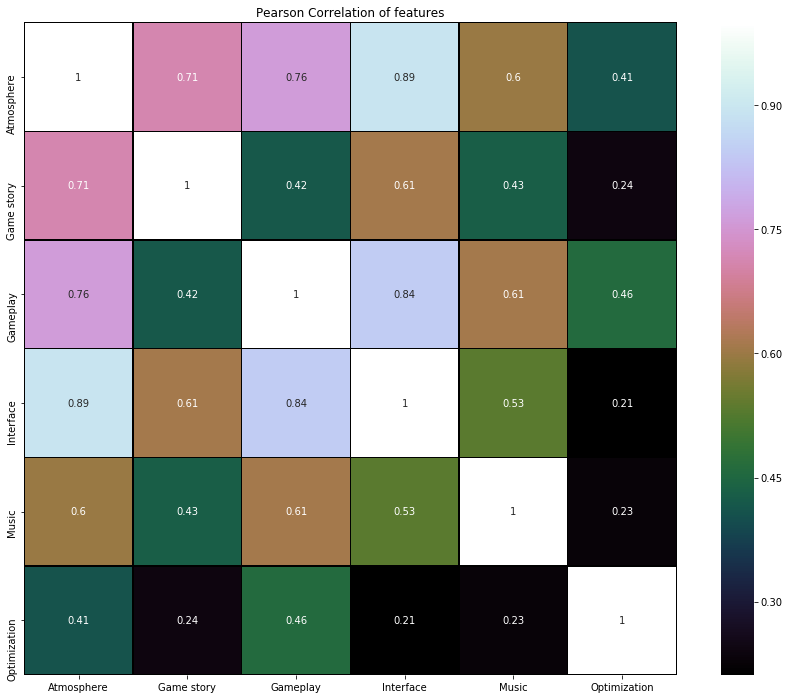

In [104]:
str_list = [] # empty list to contain columns with strings (words)
for colname, colvalue in data2.iteritems():
    if type(colvalue[1]) == str:
         str_list.append(colname)
# Get to the numeric columns by inversion            
num_list = data2.columns.difference(str_list) 
# Create Dataframe containing only numerical features
data2_num = data2[num_list]
f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation of features')
# Draw the heatmap using seaborn
#sns.heatmap(house_num.astype(float).corr(),linewidths=0.25,vmax=1.0, square=True, cmap="PuBuGn", linecolor='k', annot=True)
sns.heatmap(data2_num.astype(float).corr(),linewidths=0.25,vmax=1.0, square=True, cmap="cubehelix", linecolor='k', annot=True)

In [117]:
from sklearn.ensemble.forest import RandomForestClassfier
from sklearn.feature_selection import SelectFromModel

ImportError: cannot import name 'RandomForestClassfier' from 'sklearn.ensemble.forest' (C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.16398808 0.13997119 0.21247215 0.15852036 0.1542307  0.17081753]


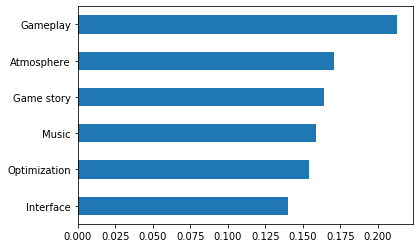

In [120]:
X = data2.iloc[:,1:7]  #independent columns
y = data2.iloc[:,7]    #target column i.e price range
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nsmallest(10).plot(kind='barh')
plt.show()

In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [6]:
data= pd.read_excel('games_evaluation.xlsx')

In [7]:
rate = ['6.8','6.4','5.5','5.9','6.6','5.2','7.4','6.2','5.9','7.6','7.3','6','6.1','6.3','6.5','6.3','6.5','6.5','7.1']
data['Rate']=rate

In [8]:
data.head(19)

,Name,Game story,Interface,Gameplay,Music,Optimization,Atmosphere,Rate
0,Battlefield 5,5.7,7.5,7.1,6.7,6.5,7.3,6.8
1,Mafia 3,6.1,6.7,6.5,7.3,5.4,6.2,6.4
2,No Man's Sky,4.9,5.4,5.6,6.1,5.8,5.5,5.5
3,Watch Dogs 1,4.3,6.5,6.3,6.1,6.1,6.3,5.9
4,Assassin's Creed Unity,7.0,7.0,6.4,7.1,5.2,7.1,6.6
5,Call of duty\nAdvanced warfare,6.6,7.6,7.3,6.5,6.7,7.0,5.2
6,Fallout 76,4.7,5.3,5.6,5.7,5.0,4.9,7.4
7,Batman: Arkham Knight,8.1,7.9,7.5,6.9,6.4,7.7,6.2
8,Warcraft III: Reforged,7.5,6.0,5.0,5.9,6.1,6.5,5.9
9,Aliens: Colonial Marines,5.1,6.1,5.8,5.9,6.5,6.2,7.6


In [9]:
X = data.iloc[:,1:7] #independent columns
y = data.iloc[:,7] 

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=0)

In [12]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)
clf.fit(X_train, y_train)

for feature in zip(clf.feature_importances_):
    print(feature)

(0.16182615038673656,)
(0.16605691495971103,)
(0.17981948609677764,)
(0.18139179985354054,)
(0.13568537692716626,)
(0.1752202717760679,)


In [13]:
sfm = SelectFromModel(clf, threshold=0.15)
sfm.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=10000, n_jobs=-1,
                                                 oob_score=False,
                                                 random_state=0, verbose=0,
     

In [14]:
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

In [15]:
# Create a new random forest classifier for the most important features
clf_important = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

# Train the new classifier on the new dataset containing the most important features
clf_important.fit(X_important_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10000,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [16]:
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.08333333333333333

In [17]:
y_important_pred = clf_important.predict(X_important_test)
accuracy_score(y_test, y_important_pred)

0.08333333333333333